In [1]:
from transformers import (
    AutoTokenizer,
    BertTokenizerFast,
)
from custom import MammoCLIP, MammogramDataset, MammogramPreprocessor, MammogramTransform, Config
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from richtqdm import RichTqdm
import numpy as np
from utils import freeze_submodules

In [2]:
project_dir = "./mammoclip-v1"
csv_path = "./data/complete-mammo.csv"

In [3]:
Config(
    project_dir=project_dir,
    seed=42,
    csv_path=csv_path,
    freeze_text_model=True,
    freeze_vision_model=True,
    training_params=dict(
        num_epochs=300,
        train_fraction=0.8,
        batch_size=8,
        lr_max=1e-4,
        lr_min=5e-7,
        lr_scheduler="wsd_schedule",
        warmup_fraction=0.05,
        steady_fraction=0.25,
        gradient_accumulation_steps=1,
        max_grad_norm=1.0,
        weight_decay=1e-6,
        mixed_precision="bf16",
    ),
    dl_workers=dict(train=4, val=4),
    train_ds=dict(
        class_="MammogramDataset",
        attrs_=dict(
            path_to_df=os.path.join(project_dir, "train.csv"),
            weights_col="weight",
            pid_col="id",
            image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
            text_col="report",
            alt_text_cols=["aug_report"],
            image_preprocessor=dict(
                class_="MammogramPreprocessor",
                attrs_=dict(
                    output_size=(518, 518),
                    use_clahe=True,
                    extract_largest_cc=True,
                ),
            ),
            transform_function=dict(
                class_="MammogramTransform",
                attrs_=dict(
                    size=(518, 518),
                    degrees=10,
                    translate=(0.05, 0.05),
                    scale=(0.9, 1.1),
                    shear=(10, 10),
                    mean=(0.281,),
                    std=(0.217,),
                    noise_std=(0.0, 0.03),
                    is_validation=False,
                ),
            ),
            tokenizer_kwargs=dict(
                padding="max_length",
                truncation=True,
                max_length=256,
                return_tensors="pt",
            ),
            alt_text_prob=0.5,
            cache_dir=".cache",
            tokenizer="microsoft/BiomedVLP-CXR-BERT-general",
        ),
    ),
    val_ds=dict(
        class_="MammogramDataset",
        attrs_=dict(
            path_to_df=os.path.join(project_dir, "val.csv"),
            pid_col="id",
            image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
            text_col="report",
            # weights_col="weight",
            # alt_text_cols=["aug_report"],
            image_preprocessor=dict(
                class_="MammogramPreprocessor",
                attrs_=dict(
                    output_size=(518, 518),
                    use_clahe=True,
                    extract_largest_cc=True,
                ),
            ),
            transform_function=dict(
                class_="MammogramTransform",
                attrs_=dict(
                    size=(518, 518),
                    degrees=10,
                    translate=(0.05, 0.05),
                    scale=(0.9, 1.1),
                    shear=(20, 20),
                    mean=(0.281,),
                    std=(0.217,),
                    noise_std=(0.0, 0.03),
                    is_validation=True,
                ),
            ),
            tokenizer_kwargs=dict(
                padding="max_length",
                truncation=True,
                max_length=256,
                return_tensors="pt",
            ),
            alt_text_prob=0.0,
            cache_dir=".cache",
            tokenizer="microsoft/BiomedVLP-CXR-BERT-general",
        ),
    ),
    eval_interval=1,
    save_interval=1,
    max_checkpoints=5,
    pretrained_model_cfg=dict(
        vision_model_name_or_path="microsoft/rad-dino",
        text_model_name_or_path="microsoft/BiomedVLP-CXR-BERT-general",
        num_views=4,
        verbose=False,
    ),
).to_yaml("./config.yaml")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedVLP-CXR-BERT-general")

In [3]:
def find_token_usage(reports_list: list[str], tokenizer: BertTokenizerFast)->int:
    """
    Find the maximum token usage for a list of reports.
    """
    num_tokens = []
    for report in RichTqdm(reports_list):
        if len(report.strip()) < 5:
            continue
        tokens = tokenizer.__call__(report, return_tensors="pt")
        num_tokens.append(len(tokens["input_ids"][0]))
    return num_tokens

In [4]:
token_usage = find_token_usage(
    pd.read_csv("./data/complete-mammo.csv").aug_report.astype(str).tolist()+
    pd.read_csv("./data/complete-mammo.csv").report.astype(str).tolist(),
    tokenizer,
)

Output()

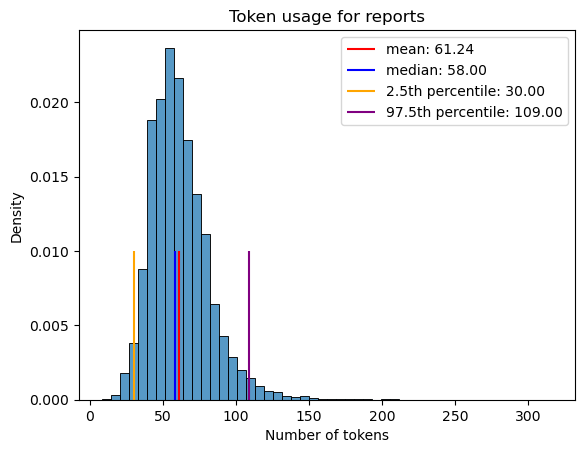

In [5]:
sns.histplot(token_usage, stat="density", bins=50);
plt.vlines(x=np.mean(token_usage), ymin=0, ymax=0.01, color="red", label=f"mean: {np.mean(token_usage):.2f}")
plt.vlines(x=np.median(token_usage), ymin=0, ymax=0.01, color="blue", label=f"median: {np.median(token_usage):.2f}")
plt.vlines(x=np.percentile(token_usage, 2.5), ymin=0, ymax=0.01, color="orange", label=f"2.5th percentile: {np.percentile(token_usage, 2.5):.2f}")
plt.vlines(x=np.percentile(token_usage, 97.5), ymin=0, ymax=0.01, color="purple", label=f"97.5th percentile: {np.percentile(token_usage, 97.5):.2f}")
plt.legend()
plt.title("Token usage for reports")
plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.show()

In [4]:
ds = MammogramDataset(
    path_to_df="./data/complete-mammo.csv",
    pid_col="id",
    image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
    text_col="report",
    alt_text_cols="aug_report",
    weights_col="weight",
    transform_function=MammogramTransform(
        size=(518, 518),
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1),
        shear=(20, 20),
        mean=(0.281,),
        std=(0.217,),
        noise_std=(0.0, 0.03),
        is_validation=False,
    ),
    alt_text_prob=0.5,
    image_preprocessor=MammogramPreprocessor((518, 518)),
    tokenizer=tokenizer,
    tokenizer_kwargs={
        "padding": "max_length",
        "truncation": True,
        "max_length": 256,
        "return_tensors": "pt",
    },
)
ds.clear_cache()

In [5]:
ds = MammogramDataset.from_dict(ds.to_dict())
(ds.to_dict())

{'class_': 'MammogramDataset',
 'attrs_': {'path_to_df': './data/complete-mammo.csv',
  'weights_col': 'weight',
  'pid_col': 'id',
  'image_cols': ['r_cc', 'l_cc', 'r_mlo', 'l_mlo'],
  'text_col': 'report',
  'alt_text_cols': ['aug_report'],
  'image_preprocessor': {'class_': 'MammogramPreprocessor',
   'attrs_': {'output_size': (518, 518),
    'use_clahe': True,
    'extract_largest_cc': True}},
  'transform_function': {'class_': 'MammogramTransform',
   'attrs_': {'size': (518, 518),
    'degrees': 10,
    'translate': (0.05, 0.05),
    'scale': (0.9, 1.1),
    'shear': (20, 20),
    'mean': (0.281,),
    'std': (0.217,),
    'noise_std': (0.0, 0.03),
    'is_validation': False}},
  'tokenizer_kwargs': {'padding': 'max_length',
   'truncation': True,
   'max_length': 256,
   'return_tensors': 'pt'},
  'alt_text_prob': 0.5,
  'cache_dir': '.cache',
  'tokenizer': 'microsoft/BiomedVLP-CXR-BERT-general'}}

In [6]:
sampler = WeightedRandomSampler(
    weights=ds.get_weights(),
    num_samples=len(ds),
    replacement=True
)

In [7]:
dl = DataLoader(ds, batch_size=4, sampler=sampler)

In [10]:
@torch.no_grad()
def find_mean_std(dataloader: DataLoader, num_samples: int = 100):
    mean_sum = 0
    std_sum = 0
    running_mean = []
    running_std = []
    n_samples = 0
    for sample in (pbar := RichTqdm(dataloader, total=num_samples//dataloader.batch_size)):
        batch_samples = sample.input_ids.shape[0]
        images = sample.pixel_values
        
        images = images.view(batch_samples, -1)
        
        mean_sum += images.mean(1).sum().item()
        std_sum += images.std(1).sum().item()
        n_samples += batch_samples
        
        running_mean.append(mean_sum / n_samples)  
        running_std.append(std_sum / n_samples)    
        
        pbar.set_description(desc=f"Mean: {running_mean[-1]:.4f}, Std: {running_std[-1]:.4f}")
        
        if n_samples >= num_samples:
            break
    return running_mean, running_std

In [11]:
def find_and_plot_meanstd(dl: DataLoader, num_samples: int = 400):
    rmean, rstd = find_mean_std(dl, num_samples)
    sns.lineplot(rmean, label="Running Mean")
    sns.lineplot(rstd, label="Running Std")
    plt.hlines(rmean[-1], 0, len(rmean), colors='r', linestyles='dashed', label=f"Final Mean: {rmean[-1]:.3f}", alpha=0.5)
    plt.hlines(rstd[-1], 0, len(rstd), colors='g', linestyles='dashed', label=f"Final Std: {rstd[-1]:.3f}", alpha=0.5)
    plt.legend()
    plt.grid()
    plt.title("Running Mean and Std")
    plt.xlabel("Batch Number")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [8]:
# load a sample
sample = next(iter(dl))

In [9]:
type(sample), sample.keys()

(transformers.tokenization_utils_base.BatchEncoding,
 dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values']))

In [10]:
sample["pixel_values"].shape, sample["input_ids"].shape

(torch.Size([4, 4, 518, 518]), torch.Size([4, 256]))

In [11]:
sample["input_ids"][3]

tensor([    2,  1689,  3488, 12402,  1752,  5555,  5179,    12,  3488,  4894,
           43,    13,    18,  2009,  1752,    43,  1909,    17,  3698, 27634,
         2520,  2902,  1719,  2752, 16113,  1690,  1689,  3802,  8465, 11787,
         1694,  1689,  2279,  3488,    18,    43, 27634,  2520,  2902,  1719,
         2752,  8539,  1700, 16113,  5940,  4025,    66,  2529,  2484,  1690,
         1689,    23,    57,    11, 13203,  3392,  1694,  1689,  2279,  3488,
         1752,  3211,    12,  3888,  7282,    30,    25,    13,    18,  3888,
         7282,    30,    25,    16,  3662,  9620,  1694,  8004,    18,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

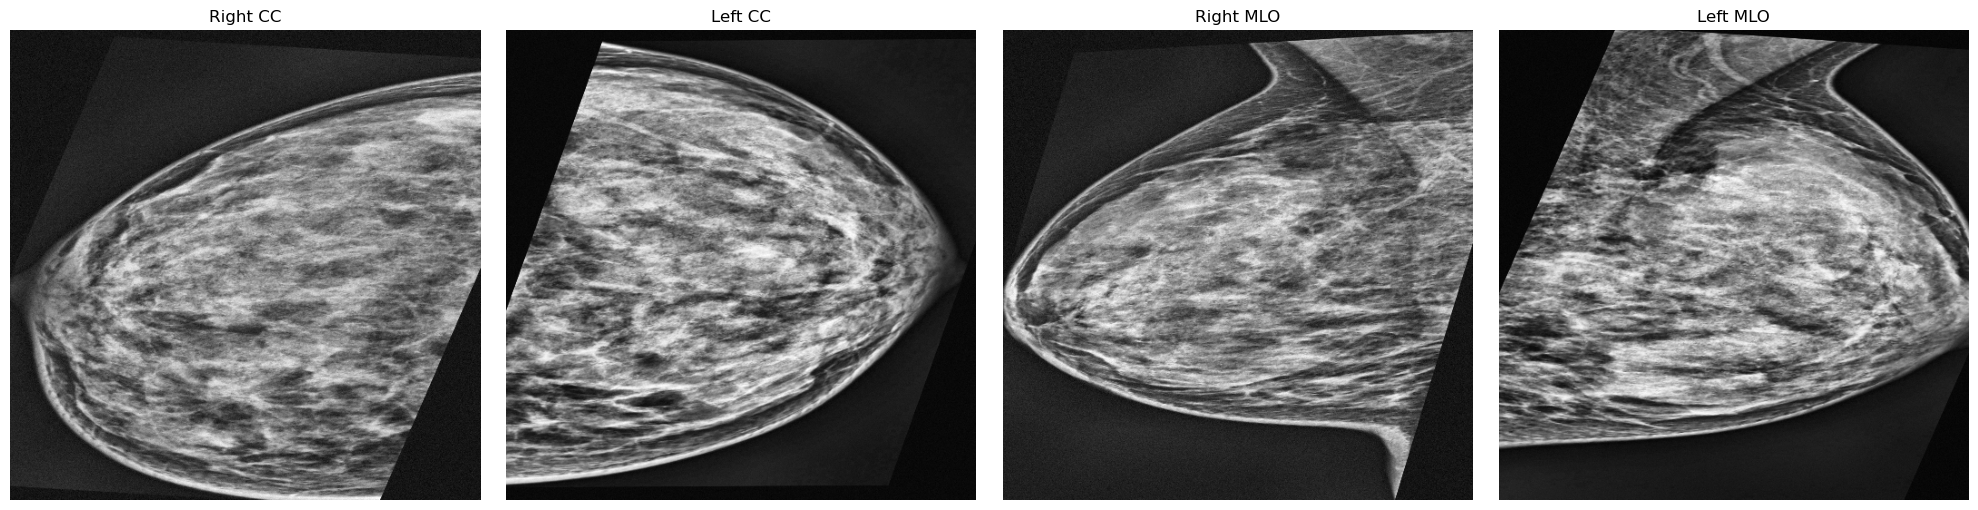

In [12]:
# show the image, each channel is a view
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(sample.pixel_values[0][i], cmap="gray")
    axs[i].axis("off")
axs[0].set_title("Right CC")
axs[1].set_title("Left CC")
axs[2].set_title("Right MLO")
axs[3].set_title("Left MLO")
plt.tight_layout()
plt.show()

In [13]:
model = MammoCLIP.from_vision_text_pretrained(
    "microsoft/rad-dino", "microsoft/BiomedVLP-CXR-BERT-general", num_views=4, verbose=True
)

The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 4 views.


In [15]:
freeze_submodules(model, [model.text_model, model.vision_model])

In [16]:
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params:,}")
print(f"Number of trainable parameters: {num_trainable_params:,} ({num_trainable_params/num_params:.2%})")

Number of parameters: 197,147,906
Number of trainable parameters: 1,085,186 (0.55%)


In [19]:
with torch.inference_mode():
    outputs = model(
        **sample,
        return_loss=True,
    )

Processing images with shape: torch.Size([4, 4, 518, 518]) (bs, c, h, w)
Stacked images shape: torch.Size([4, 4, 768]), Embedded images shape: torch.Size([4, 4, 768])
Fused embedding shape: torch.Size([4, 768]), Attention weights shape: torch.Size([4, 4])


In [20]:
loss, logits_per_image = outputs.loss, outputs.logits_per_image  # this is the image-text similarity score


In [21]:
print("Contrastive training loss:", loss.item())

Contrastive training loss: 1.3781847953796387


In [22]:
print("Logits per image:\n", logits_per_image)

Logits per image:
 tensor([[ 0.1685,  0.0280, -0.0810,  0.2050],
        [ 0.3641,  0.1891,  0.0383,  0.3613],
        [ 0.2853,  0.1125,  0.0533,  0.3290],
        [ 0.1186,  0.0172, -0.1838,  0.1948]])


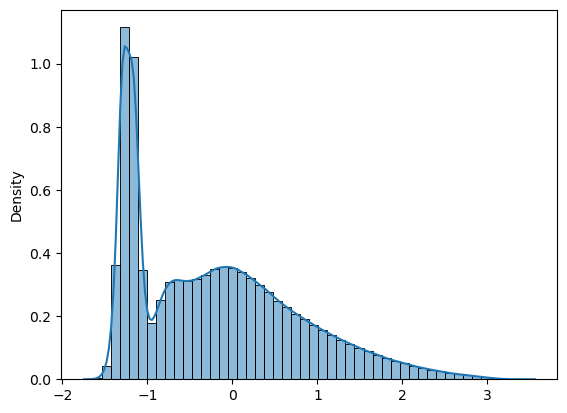

In [23]:
sns.histplot(sample.pixel_values.flatten(), bins=50, kde=True, stat="density")
plt.show()

In [24]:
# read the parameters to check
for name, param in model.named_parameters():
    if name == "vision_fused_attn.attention_net.0.weight":
        print(name, param.data)
        break

vision_fused_attn.attention_net.0.weight tensor([[-0.0221, -0.0294, -0.0260,  ...,  0.0360, -0.0063, -0.0298],
        [-0.0214,  0.0135,  0.0173,  ..., -0.0121,  0.0135,  0.0147],
        [-0.0305, -0.0323,  0.0331,  ..., -0.0123, -0.0120, -0.0050],
        ...,
        [ 0.0074, -0.0341, -0.0215,  ..., -0.0227,  0.0271, -0.0280],
        [ 0.0164, -0.0182,  0.0209,  ...,  0.0122, -0.0297,  0.0154],
        [-0.0209,  0.0117, -0.0048,  ..., -0.0127, -0.0226,  0.0150]])


In [25]:
model.save_pretrained("./mammoclip-model")

In [26]:
model = MammoCLIP.from_pretrained("./mammoclip-model")

You are using a model of type mammo_clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.


In [27]:
# read the parameters to check
for name, param in model.named_parameters():
    if name == "vision_fused_attn.attention_net.0.weight":
        print(name, param.data)
        break

vision_fused_attn.attention_net.0.weight tensor([[-0.0221, -0.0294, -0.0260,  ...,  0.0360, -0.0063, -0.0298],
        [-0.0214,  0.0135,  0.0173,  ..., -0.0121,  0.0135,  0.0147],
        [-0.0305, -0.0323,  0.0331,  ..., -0.0123, -0.0120, -0.0050],
        ...,
        [ 0.0074, -0.0341, -0.0215,  ..., -0.0227,  0.0271, -0.0280],
        [ 0.0164, -0.0182,  0.0209,  ...,  0.0122, -0.0297,  0.0154],
        [-0.0209,  0.0117, -0.0048,  ..., -0.0127, -0.0226,  0.0150]])


In [28]:
print(f"number of parameters: {sum(p.numel() for p in model.parameters()):,}")

number of parameters: 197,147,906
